In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix

In [2]:
wine_path = "/content/drive/MyDrive/dataset/wine/wine.data"

data = pd.read_csv(wine_path, header = None, delimiter=",")

You can change the path to your dataset.

In [3]:
data.columns = [
                                        #features
    "Class",
    "Alcohol",
    "Malic_Acid",
    "Ash",
    "Alcalinity_of_Ash",
    "Magnesium",
    "Total_phenols",
    "Flavanoids",
    "Nonflavanoid_phenols",
    "Proanthocyanins",
    "Color_intensity",
    "Hue",
    "OD280/OD315_of_diluted_wines",
    "Proline"
]

selected_features = [               # this is for manuel feature selection, you can select any features you want
                                    # compare and test different feature sets to see which one performs best
    #"Class",                       # If you want only two features, e.g., "Alcohol", "Ash" then:
    "Alcohol",                      # selected_features = ["Alcohol", "Ash"]
    "Malic_Acid",
    "Ash",
    "Alcalinity_of_Ash",            # in selected_features we need to extract the class
    "Magnesium",                    # so, class feature has commented
    "Total_phenols",
    "Flavanoids",
    "Nonflavanoid_phenols",
    "Proanthocyanins",
    "Color_intensity",
    "Hue",
    "OD280/OD315_of_diluted_wines",
    "Proline"
]

You can compare any feature you want.
Just make comment or delete the unnecessary features.


In [4]:
# Use only the selected features for X
X = data[selected_features]
y = data["Class"]

print("X shape:", X.shape)       # (178, 13) if file had no header row
print("y shape:", y.shape)
print(data.head())

X shape: (178, 13)
y shape: (178,)
   Class  Alcohol  Malic_Acid   Ash  Alcalinity_of_Ash  Magnesium  \
0      1    14.23        1.71  2.43               15.6        127   
1      1    13.20        1.78  2.14               11.2        100   
2      1    13.16        2.36  2.67               18.6        101   
3      1    14.37        1.95  2.50               16.8        113   
4      1    13.24        2.59  2.87               21.0        118   

   Total_phenols  Flavanoids  Nonflavanoid_phenols  Proanthocyanins  \
0           2.80        3.06                  0.28             2.29   
1           2.65        2.76                  0.26             1.28   
2           2.80        3.24                  0.30             2.81   
3           3.85        3.49                  0.24             2.18   
4           2.80        2.69                  0.39             1.82   

   Color_intensity   Hue  OD280/OD315_of_diluted_wines  Proline  
0             5.64  1.04                          3.92   

The first 5 lines were printed to check which labels correspond to which dataset and to see that they are sorted correctly.

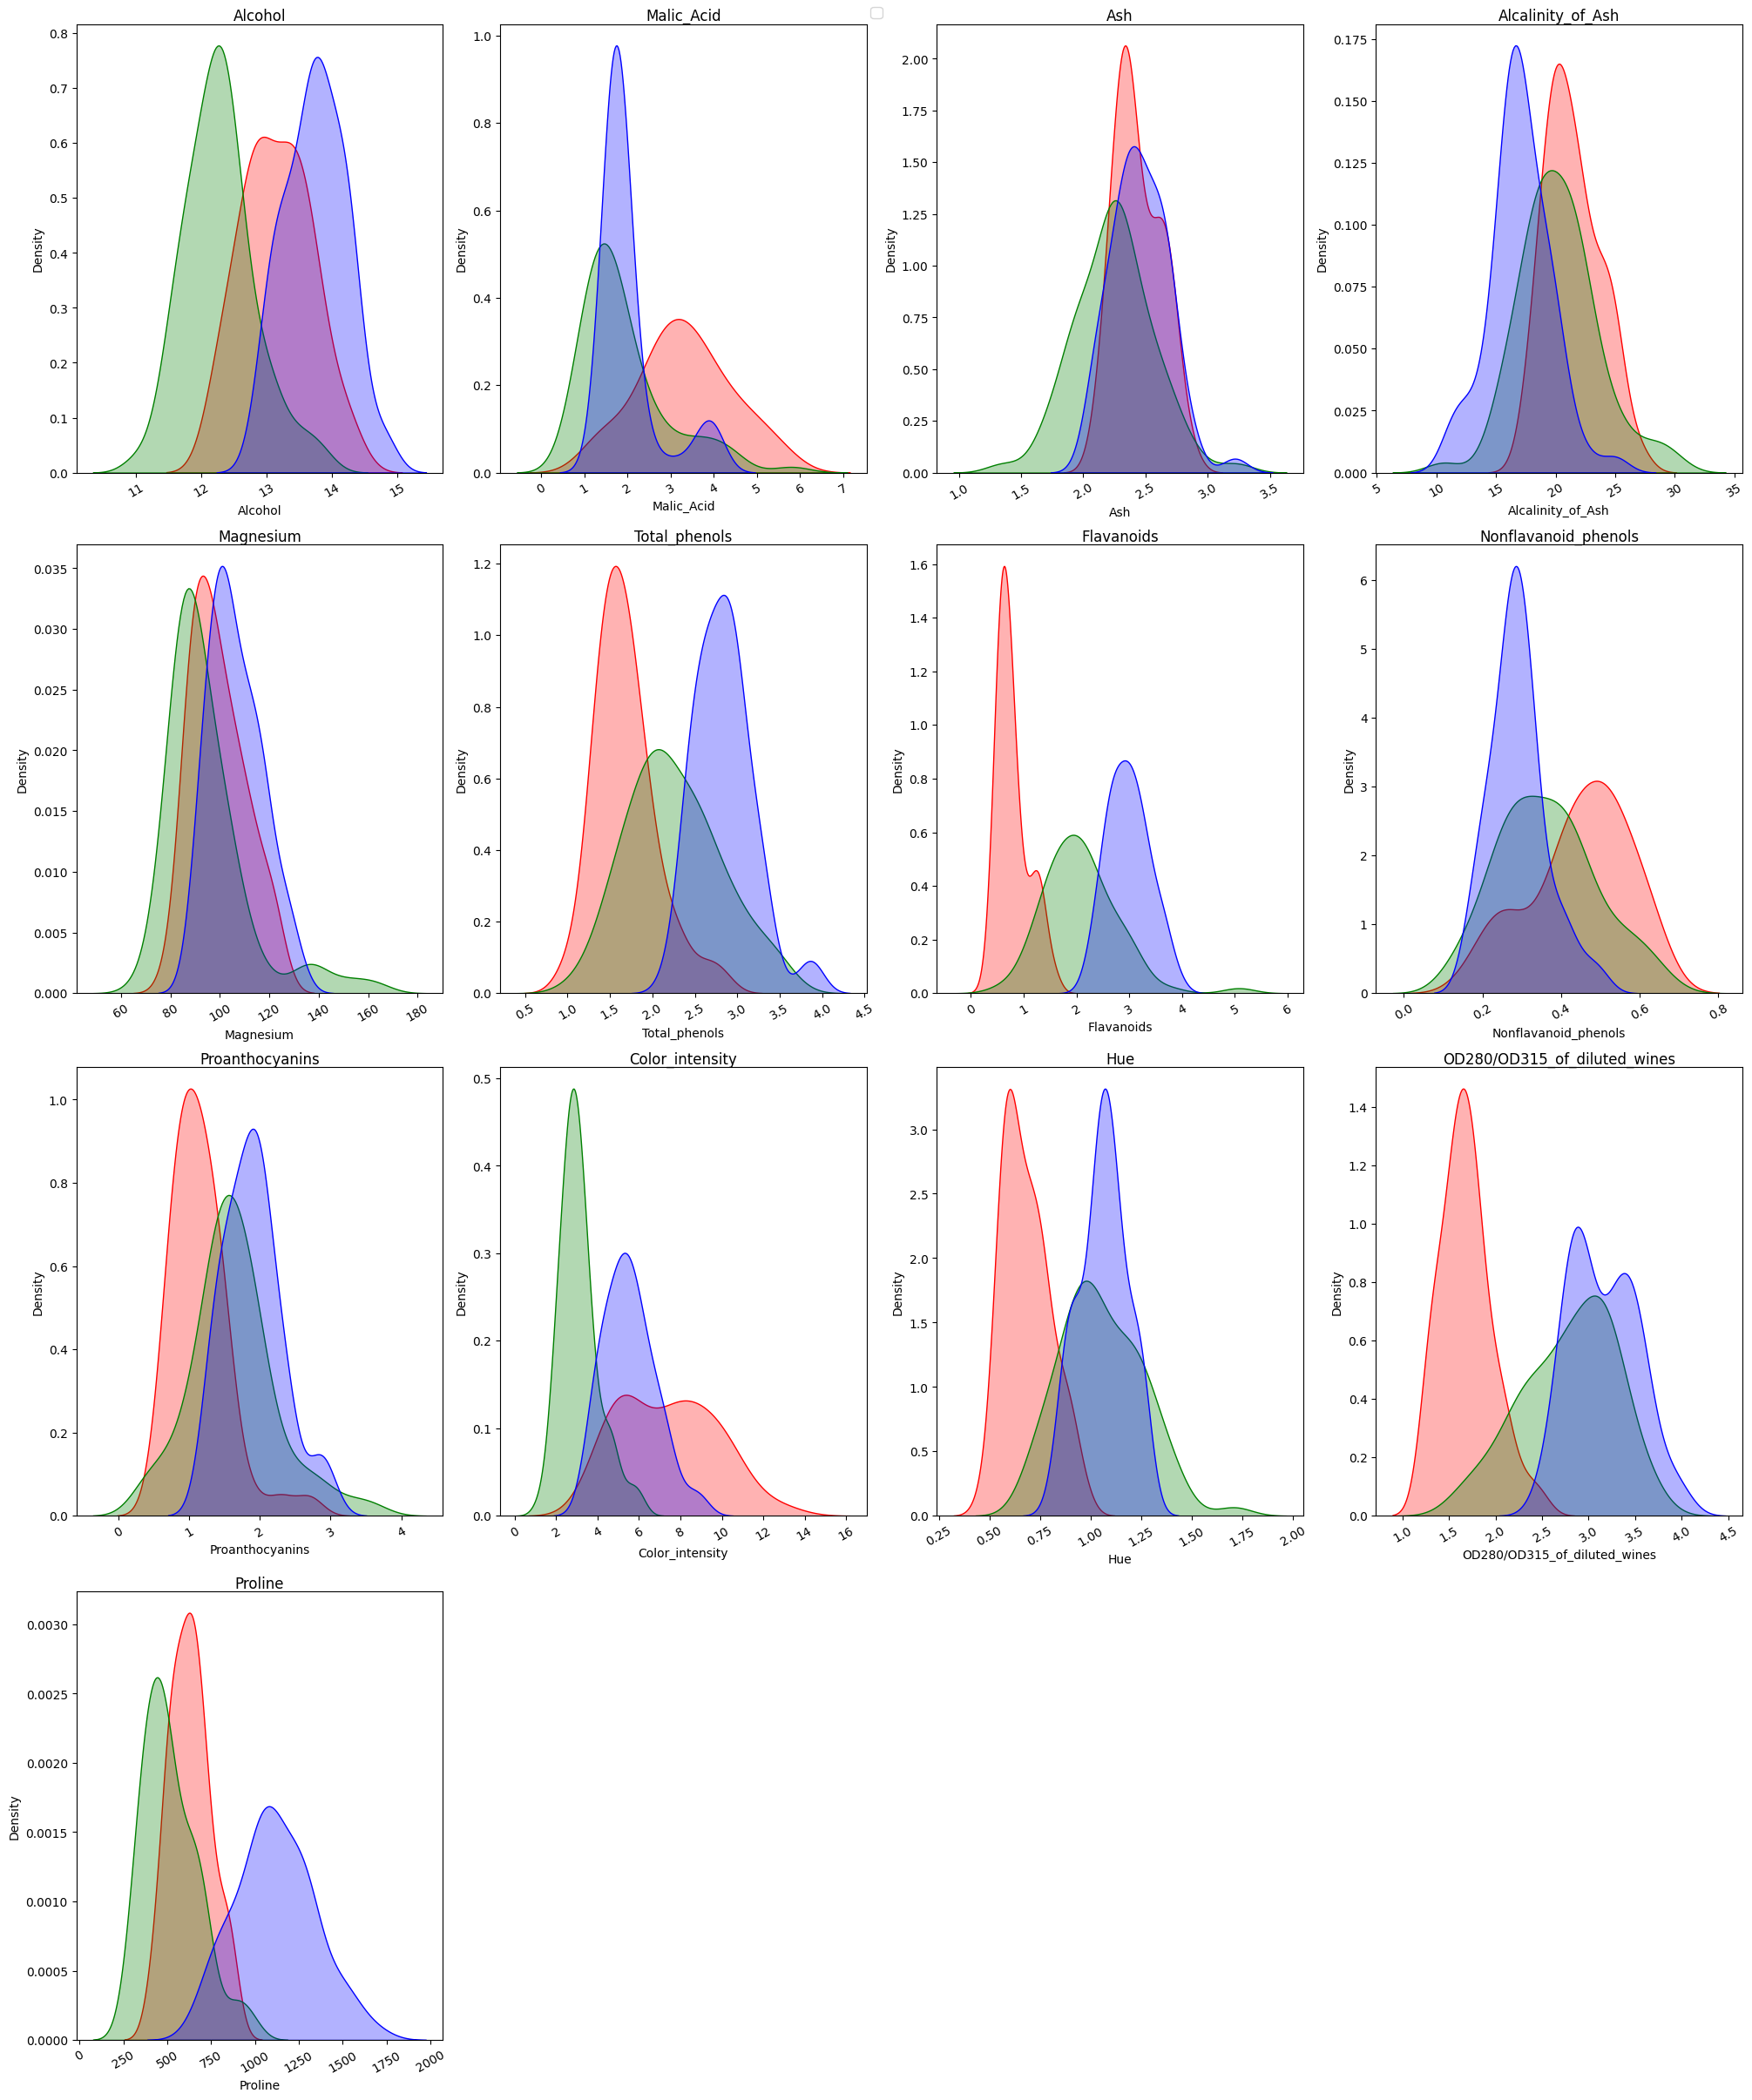

In [5]:
features    = data.columns.drop("Class")    #drop class label

rows, cols  = 4,4

fig, axes   = plt.subplots(rows, cols, figsize=(20, 24), constrained_layout=True)   #'constrained_layout' = True
                                                                                    # ----> auto adjust the size of the subplots to fit the figure
axes        = axes.flatten()

color_palette   = ["blue", "green", "red"]  #blue ----> class_1
class_order     = [1, 2, 3]                 #green----> class_2
                                            #red  ----> class_3

#  kernel density estimate (KDE) -----------> draw the density of each feature for each class
                                            # to compare the distribution of the features
for i, feat in enumerate(features):         # to find the best features to separate the classes
    ax = axes[i]
    sns.kdeplot(
        data        = data,
        x           = feat,
        hue         = "Class",
        hue_order   = class_order,
        palette     = color_palette,
        fill        = True,
        alpha       = 0.3,
        common_norm = False,    #normalize each class seperately
        ax          = ax,
        legend      = False
    )
    ax.set_title    (feat, fontsize=12, pad=0)
    ax.tick_params  (axis='x', labelsize=10, rotation=30)
    ax.tick_params  (axis='y', labelsize=10)

for j in range  (len(features), rows * cols):
    fig.delaxes (axes[j])                       #delate empty subplots

handles, labels = axes[0].get_legend_handles_labels()   #take legend handles and labels from the first subplot

unique_handles  = []
unique_labels   = []

for h, l in zip(handles, labels):   #same class name may be repeated, we create a list without repeats
    if l not in unique_labels:
        unique_labels.append(l)
        unique_handles.append(h)

fig.legend(unique_handles, unique_labels, loc='upper center', ncol=3, fontsize=12)

plt.show()

You can see the distribution of features according to classes. **These graphs can be an important parameter in choosing which features will give the best performance for the model.**

In [6]:
#split into train / test
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size   = 0.20,   # 20% test
    random_state= 2025,   # None, --------> we can use None seed to randomize the split for every run
    stratify    = y       # keeps class distribution balanced
)

# scaler ---> normalization
scaler          = StandardScaler()
X_train_scaled  = scaler.fit_transform(X_train)
X_test_scaled   = scaler.transform(X_test)

This can be used to change the test and training size ratios. A fixed seed can be used, or a random seed generator that changes each time can be selected. **The second option may be a more accurate option as it will be closer to real-time data readings in terms of randomness.**

In [7]:
# k-NN algorithm -------- used different distance metrics to see the difference between them
# and how they affect the model performance
def compute_distance(x1, x2, metric):

    #distance between two vectors x1 and x2
    if metric   == 'euclidean':                 #euclidean
        return np.sqrt(np.sum((x1 - x2) ** 2))
    elif metric == 'manhattan':                 #manhattan
        return np.sum (np.abs(x1 - x2))
    elif metric == 'chebyshev':                 #chebyshev
        return np.max (np.abs(x1 - x2))
    else:
        raise ValueError("unsupported distance metric.")

In [8]:
def knn_predict_single(x_test, X_train, y_train, k=1, metric=''):

    #predict the label for a single test instance x_test,
    #given training data, number of neighbors k and distance metric

    distances = []  #store distances between x_test and each training instance

    #calculate distances from x_test to every training sample
    for i, x_tr in enumerate   (X_train):
        dist = compute_distance(x_test, x_tr, metric=metric)
        distances.append       ((dist, y_train[i]))

    #sorting (for distance value) closest is the first
    distances.sort(key=lambda x: x[0])

    #select k nearest neighbors
    neighbors = distances[:k]

    neighbor_labels = [label for _, label in neighbors]         #np.bincount(neighbor_labels) function counts the number of occurrences of each label, assuming the labels are integers
    predicted_label = np.argmax(np.bincount(neighbor_labels))   #p.argmax determines the index of the tag with the highest value among these counts
                                                                #this tag becomes the predicted tag for the test example.

    return predicted_label

In [9]:
#for multiple test instances
def knn_predict(X_test, X_train, y_train, k=1, metric=''):

    predictions = []

    for x_test in X_test:
        pred = knn_predict_single(x_test, X_train, y_train, k=k, metric=metric) # call the function for each test instance
        predictions.append(pred)                                                # predicted tag is added to the predictions list
    return np.array(predictions)

In [10]:
#different k values and distance metrics
k_values    = [1, 3, 5, 7, 9]
metrics     = ['euclidean', 'manhattan','chebyshev']

results     = {}  #store accuracy results for plotting
conf_mats   = {}

In [11]:
for metric in metrics:                                                                          # in this loop using the function knn_predict()
    print(f"\n====> distance metric: {metric} <====")                                           # explicitly passing a different metric each time
    results[metric]     = []                                                                    # first "euclidean", then "manhattan", then "chebyshev"

    conf_mats[metric]   = {}                                                                    # the same thing applies to k values,
                                                                                                # they take the values ​​1,3,5,7,9 respectively.
    for k in k_values:
        # predict on test set using k-NN
        y_pred = knn_predict(X_test_scaled, X_train_scaled, y_train.values, k=k, metric=metric)

        #accuracy
        acc = accuracy_score(y_test, y_pred)
        results[metric].append(acc)

        #confusion matrix
        c_matrix = confusion_matrix(y_test, y_pred)
        conf_mats[metric][k] = c_matrix

        print(f"  k = {k}: accuracy = {acc:.4f}")
        print("  confusion matrix:\n", c_matrix, "\n")


====> distance metric: euclidean <====
  k = 1: accuracy = 0.9167
  confusion matrix:
 [[12  0  0]
 [ 1 11  2]
 [ 0  0 10]] 

  k = 3: accuracy = 0.9722
  confusion matrix:
 [[12  0  0]
 [ 0 13  1]
 [ 0  0 10]] 

  k = 5: accuracy = 0.9444
  confusion matrix:
 [[12  0  0]
 [ 1 12  1]
 [ 0  0 10]] 

  k = 7: accuracy = 0.9444
  confusion matrix:
 [[12  0  0]
 [ 1 12  1]
 [ 0  0 10]] 

  k = 9: accuracy = 0.9444
  confusion matrix:
 [[12  0  0]
 [ 1 12  1]
 [ 0  0 10]] 


====> distance metric: manhattan <====
  k = 1: accuracy = 0.9722
  confusion matrix:
 [[12  0  0]
 [ 0 13  1]
 [ 0  0 10]] 

  k = 3: accuracy = 0.9722
  confusion matrix:
 [[12  0  0]
 [ 0 13  1]
 [ 0  0 10]] 

  k = 5: accuracy = 0.9722
  confusion matrix:
 [[12  0  0]
 [ 0 13  1]
 [ 0  0 10]] 

  k = 7: accuracy = 1.0000
  confusion matrix:
 [[12  0  0]
 [ 0 14  0]
 [ 0  0 10]] 

  k = 9: accuracy = 1.0000
  confusion matrix:
 [[12  0  0]
 [ 0 14  0]
 [ 0  0 10]] 


====> distance metric: chebyshev <====
  k = 1: a

Separate k values ​​were tested for each metric.
The resulting accuracy and confusion matrices can be compared.

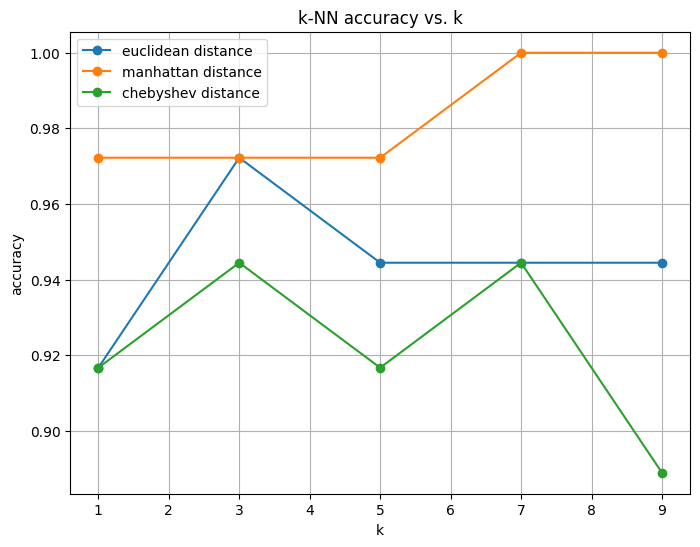

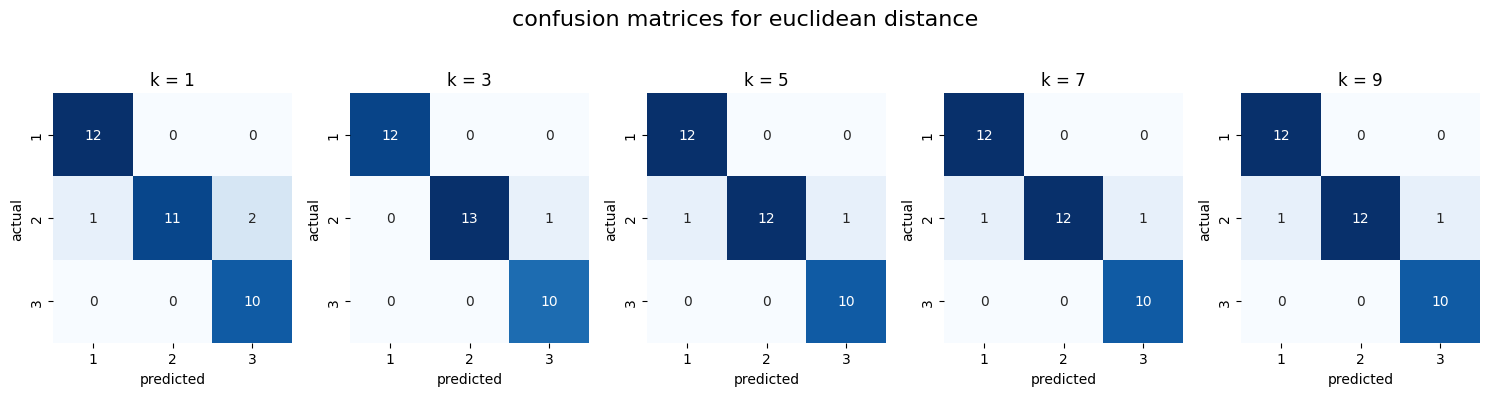

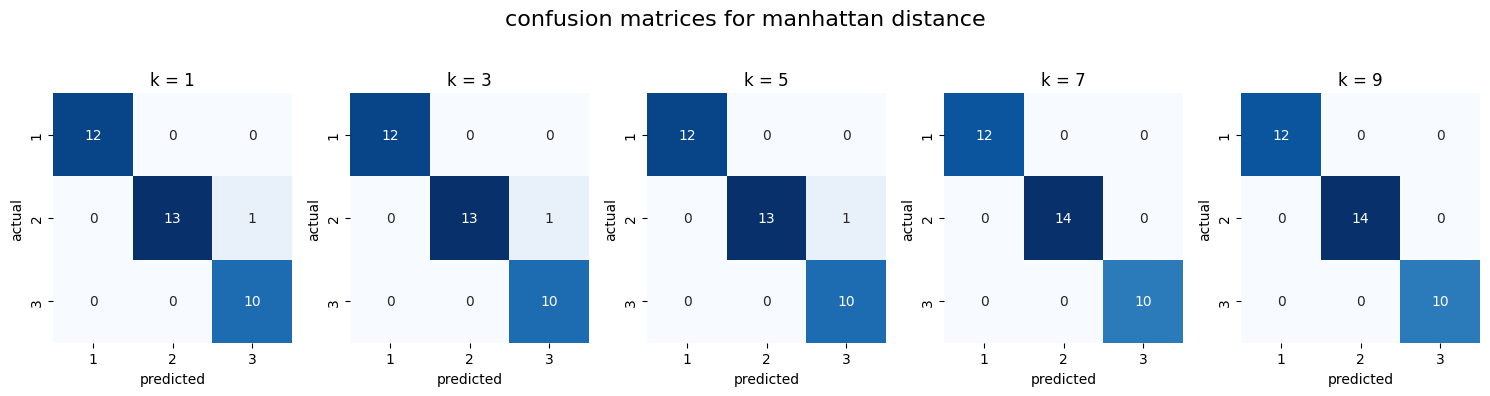

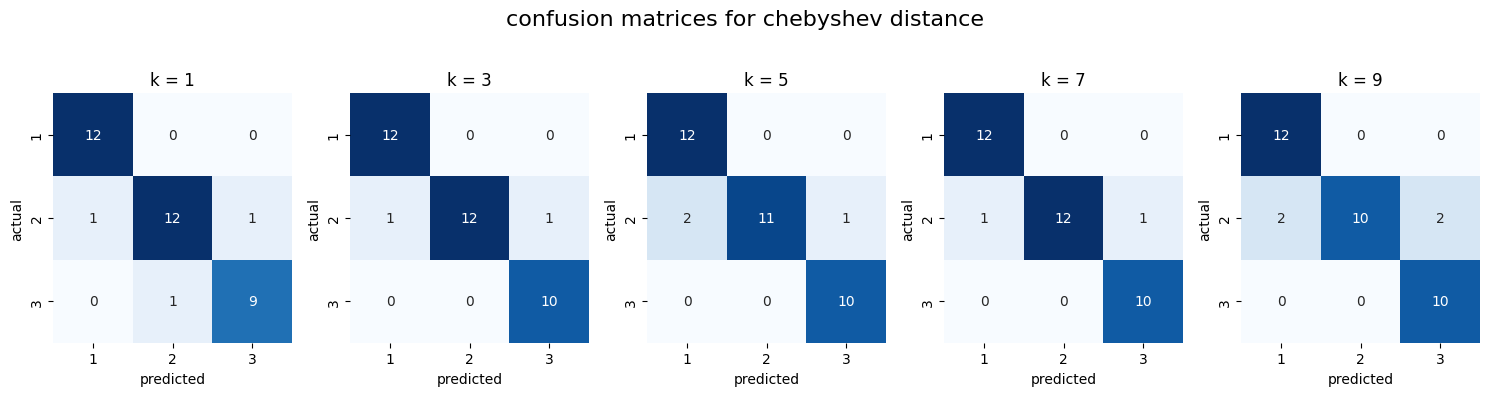

In [12]:
#plots of confusion matrix and accuracy
plt.figure(figsize=(8, 6))

for metric in metrics:
    plt.plot(k_values, results[metric], marker='o', label=f"{metric} distance")

plt.title   ("k-NN accuracy vs. k")
plt.xlabel  ("k")
plt.ylabel  ("accuracy")
plt.legend  ()
plt.grid    (True)
plt.show    ()

for metric in metrics:
    fig, axes = plt.subplots(1, len(k_values), figsize=(15, 4))
    fig.suptitle(f"confusion matrices for {metric} distance", fontsize=16)

    for idx, k in enumerate(k_values):
        c_matrix    = conf_mats[metric][k]
        ax          = axes[idx] if len(k_values) > 1 else axes
        sns.heatmap  (c_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[1, 2, 3], yticklabels=[1, 2, 3], ax=ax, cbar=False)
        ax.set_title (f"k = {k}")
        ax.set_xlabel("predicted")
        ax.set_ylabel("actual")
    plt.tight_layout (rect=[0, 0, 1, 0.95])
    plt.show()

Accuracy and confusion matrices were also drawn for a better graphical display and a easier comparison of the results.

**Different scenarios can be tried for the model by changing some parameters and keeping some parameters constant. All necessary information is explained in text boxes and as comments in code lines.**

** ⭐  Have fun ⭐ 🙂 **